<font size = "5"> **Chapter 4: [Spectroscopy](Ch4-Spectroscopy.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />


# Analysing Low-Loss Spectra with Drude Theory

part of 


<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>


by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


The main feature in a low-loss EELS spectrum is the volume plasmon peak.

The simplest theory to interprete this energy range is the Drude theory. 

Another easy to observe component is the multiple scatteringof thix plasmon peak, which we can correct for or use for thickness determination.

## First we import the relevant packages

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

# additional package 
from scipy.optimize import leastsq  ## fitting routine of scipy

import ipywidgets as ipyw

# Import libraries from the book
import pyTEMlib
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

### And we use the file tool library of pyTEMlib
import pyTEMlib.file_tools as ft



Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
windows


# Load and plot a spectrum
please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details

In [2]:

filename = './EELSdata/Si-011-CBED-20mu650mthin.dm3'
#filename = './EELSdata/Si-011-CBED-20mu650mu.dm3'


spectrum_tags = ft.open_file(filename)#os.path.join(current_directory,filename))

spectrum_tags['axis']['0']['pixels'] = len(spectrum_tags['spec'])

scale_p = spectrum_tags['axis']['0']
spectrum_tags['energy_scale'] = np.arange(scale_p['pixels'])*scale_p['scale']+scale_p['Origin']

energy_scale = spectrum_tags['energy_scale'].copy()
spectrum = spectrum_tags['spec'].copy()

#######################################
## Important Experimental Parameters ##
#######################################

spectrum_tags['eels_parameter'] = {}
spectrum_tags['eels_parameter']['integration_time_s'] = spectrum_tags['integration_time']
spectrum_tags['eels_parameter']['number_of_frames'] = spectrum_tags['number_of_frames']
spectrum_tags['eels_parameter']['acceleration_voltage_V'] = spectrum_tags['acceleration_voltage']
spectrum_tags['eels_parameter']['collectionAngle_mrad'] =50.
spectrum_tags['eels_parameter']['convergenceAngle_mrad'] =30.
spectrum_tags['eels_parameter']['integration_time'] = spectrum_tags['integration_time']

eels_p = spectrum_tags['eels_parameter']

sumSpec = sum(spectrum_tags['spec'])

spectrum_counts = spectrum
spectrum = spectrum/sumSpec*100.

plt.figure()
plt.plot(energy_scale,spectrum)
plt.title ('Spectrum '+spectrum_tags['filename']);
plt.xlabel('energy loss [eV]')
plt.ylabel('% scattering Intensity');


FileNotFoundError: [Errno 2] No such file or directory: './EELSdata/Si-011-CBED-20mu650mthin.dm3'

## Fix energy scale and resolution function
please see [Fitting the Zero-Loss Peak](FitZeroLoss.ipynb) for details

Zero Loss with energy resolution of 0.28 eV at position -0.588 eV
Fit of a Product of two Lorentzians
Positions:  -0.021585871824087575 0.1579246927478446 Distance:  -0.17951056457193218
Width:  0.22314268774361312 0.8692233952749508
Areas:  -148.89550221537206 -0.028096043869014903
Goodness of Fit: 0.00027374%


<IPython.core.display.Javascript object>


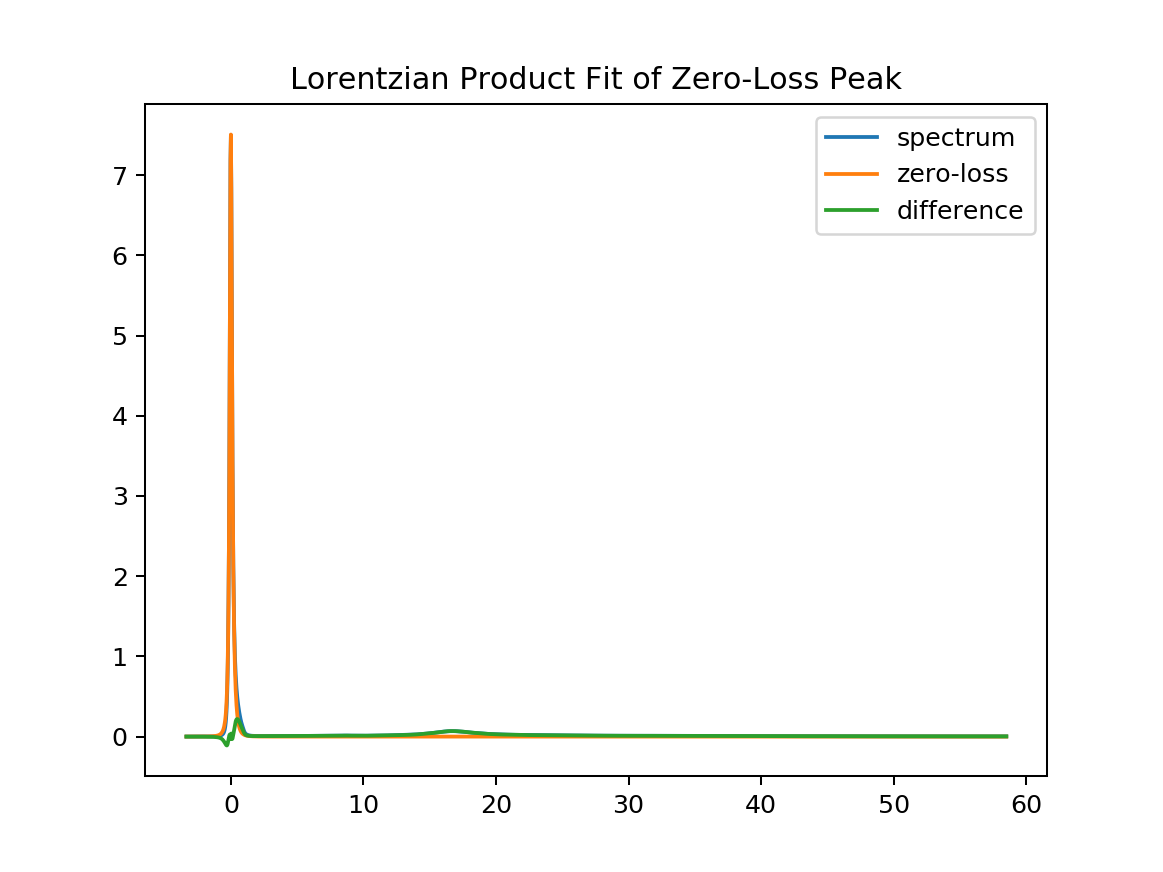

Sum of Zero-Loss: 73 counts
Sum of Spectrum: 100 counts
thickness [IMFP]: 0.31644


In [3]:
FWHM, Eshift = eelst.fixE( spectrum, energy_scale)

print(f'Zero Loss with energy resolution of {FWHM:.2f} eV at position {Eshift:.3f} eV')
energy_scale = energy_scale-Eshift

zLoss = eelst.resolution_function(energy_scale, spectrum, .4)

plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, zLoss, label = 'zero-loss')
plt.plot(energy_scale, (spectrum-zLoss) , label = 'difference')

plt.title ('Lorentzian Product Fit of Zero-Loss Peak')
#plt.xlim(-5,30)
plt.legend();
Izl = zLoss.sum()
Itotal = spectrum.sum()
tmfp = np.log(Itotal/Izl)
print(f'Sum of Zero-Loss: {Izl:.0f} counts')
print(f'Sum of Spectrum: {Itotal:.0f} counts')
print (f'thickness [IMFP]: {tmfp:.5f}')




## Single Scattering Deconvolution

Electrons that lost energy can interact with the sample again. The average path between two interaction is the above introduced IMFP $\lambda$. This multiple inelaxtic scattering is most obvious in the strongest energ-loss spectrum: the volume plasmon. This multiple scatering follows the Poisson statistic and the $n^{\rm th}$ scattering has the intensity:
$$I_n = I_0 P_n = (I_0/n!)(t/λ)^n \exp(−t/λ)$$

It can be shown the the single scattering spectrum in fourier space $s(v)$ can be derived by:

$$s(v) = I_0 \ln[j(v)/z(v)]$$

$z(v)$ beeing the Fourier transformed zero-loss peak (resolution function) and $j(v$ the spectrum in Fourier space.

The above formula would also correct for any instument broadening and a very noisy spectrum would result, so we need to convolute (multiplication in Fourier space) a new broadening function, which could be a well behaved Gaussian with slightly smaller energy width than the original zero-loss peak.

<IPython.core.display.Javascript object>


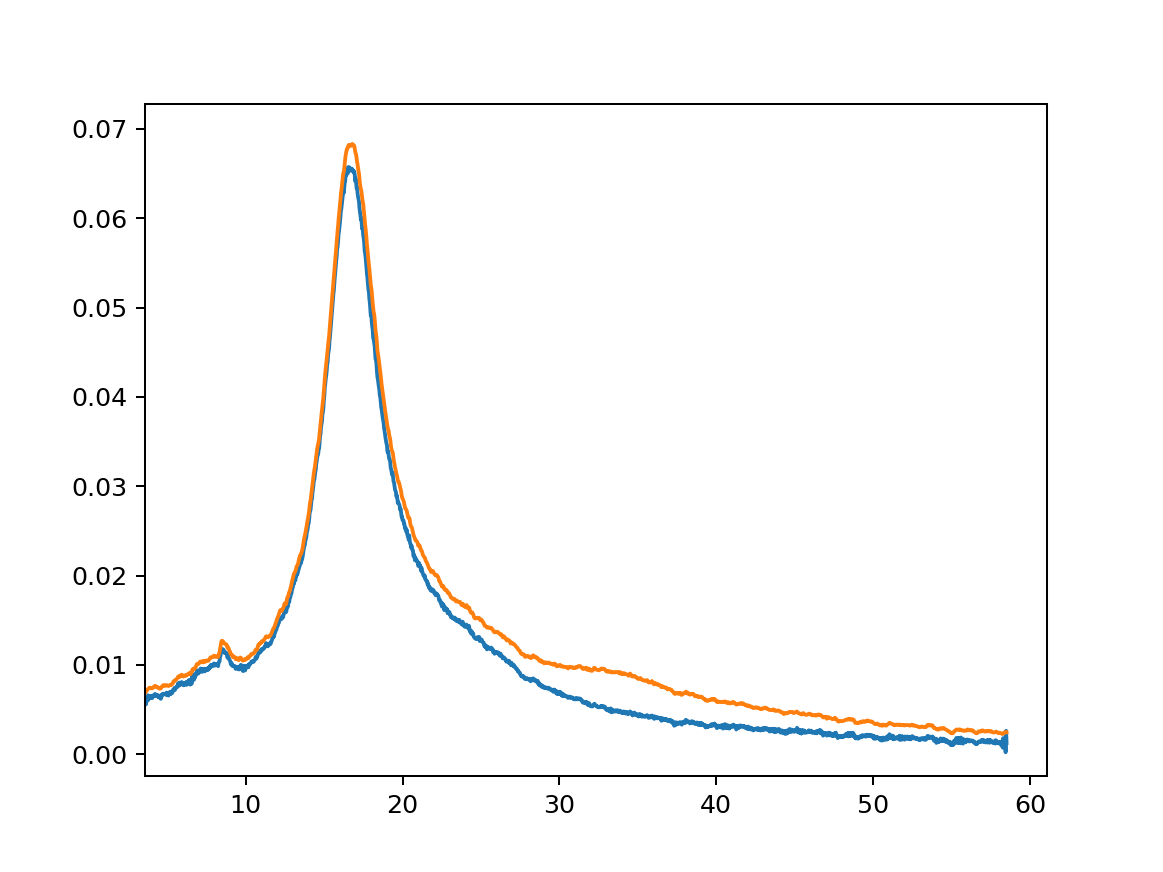

In [4]:
# Single scattering deconvolution

# Use resolution Function as ZL 

j = np.fft.fft(spectrum)
z = np.fft.fft(zLoss)
z2 = z ## Could be a different zl i.e. extracted from Spectrum
j1 = z2*np.log(j/z)
ssdLL =np.fft.ifft(j1).real#,'fourier-log deconvolution')

plt.figure()
#plt.plot(s.tags['ene'][start:end],  zLoss[start:end]/sumSpec*1e2)
plt.plot(energy_scale,  ssdLL)
plt.plot(energy_scale, spectrum)
#plt.xlim(-4,40)
plt.ylim(-.1,.1);
spectrum_tags['resFunct'] = zLoss

# Drude Function

The dielectric function in the Drude theory is given by two input parameters the position of the plasmon energy $E_p$
and the width of the plasmon $\Gamma$

$$ ε(ω) = ε1 + iε2 = 1 + χ = 1 − \frac{\omega_p^2}{\omega^2+\Gamma^2} + \frac{i\Gamma \omega_p^2}{\omega(\omega^2+\Gamma^2)}$$
Here $\omega$ is the angular frequency (rad/s) of forced oscillation and $\omega_p$ is the natural or resonance frequency for plasma oscillation, given by
$$ ω_p = \sqrt{\frac{ne^2}{(ε_0m_0)}} $$
A transmitted electron represents a sudden impulse of applied electric field, containing
all angular frequencies (Fourier components). Setting up a plasma oscillation of the loosely bound outer-shell electrons in a solid is equivalent to creating a pseudoparticle of energy $E_p = \hbar \omega_p$, known as a plasmon (Pines, 1963).

<IPython.core.display.Javascript object>


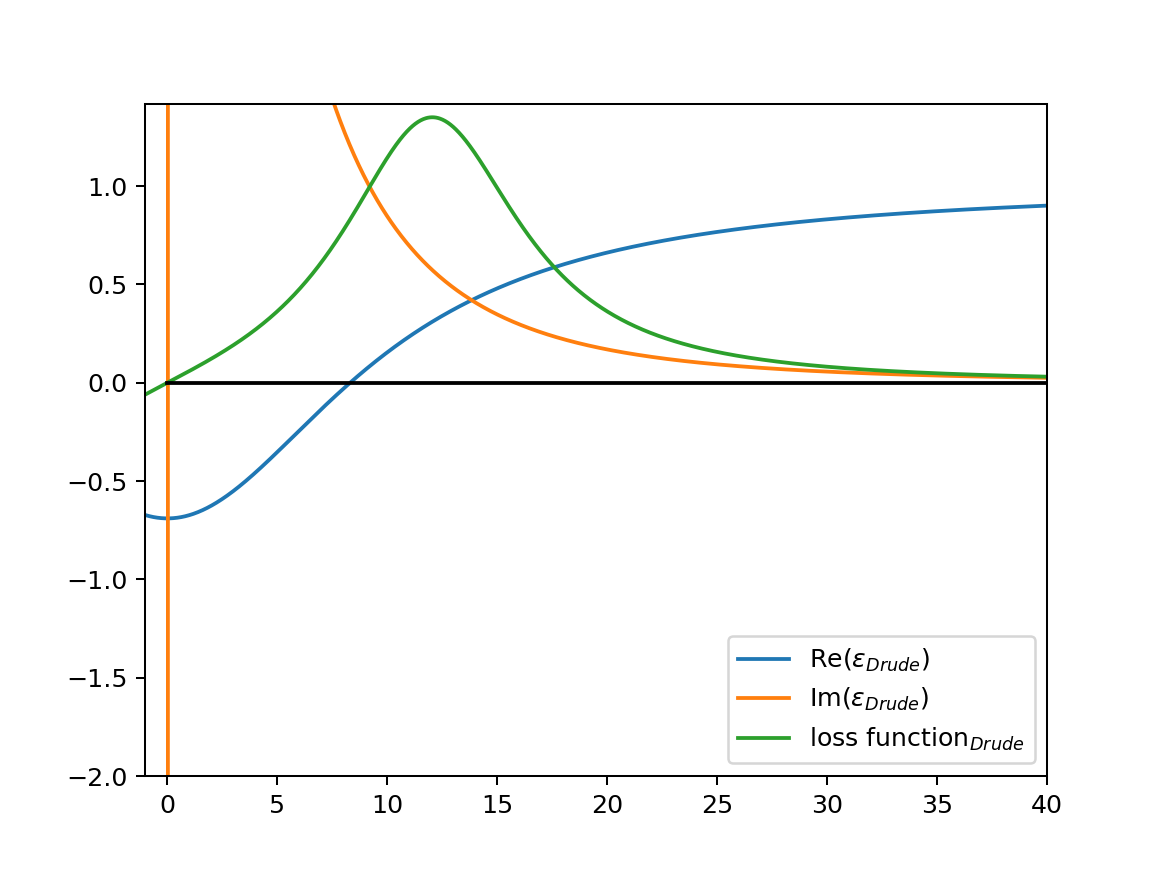

In [8]:
Ep = plasmon_energy = 13. # in eV
Ew = plasmon_gamma = 10. # in eV
E = energy_scale+1e-18 #= np.linspace(0,50,1024)+1e-18

def Drude(E,Ep,Ew):
    eps = 1 - Ep**2/(E**2+Ew**2) +1j* Ew* Ep**2/E/(E**2+Ew**2)
    elf = (-1/eps).imag
    return eps,elf

eps,elf = Drude(E,Ep,Ew)
plt.figure()
plt.plot(E, eps.real, label='Re($\epsilon_{Drude}$)')
plt.plot(E, eps.imag, label='Im($\epsilon_{Drude}$)')
plt.plot(E, elf, label='loss function$_{Drude}$')
plt.plot([0,E[-1]],[0,0],c='black')

plt.legend()
plt.gca().set_ylim(-2,max(elf)*1.05);
plt.xlim(-1,40);


# Fitting a Drude Function to Plasmon

The position and the width are important materials parameters and we can derive them by fitting the Drude function to the volume plasmon region.

<IPython.core.display.Javascript object>


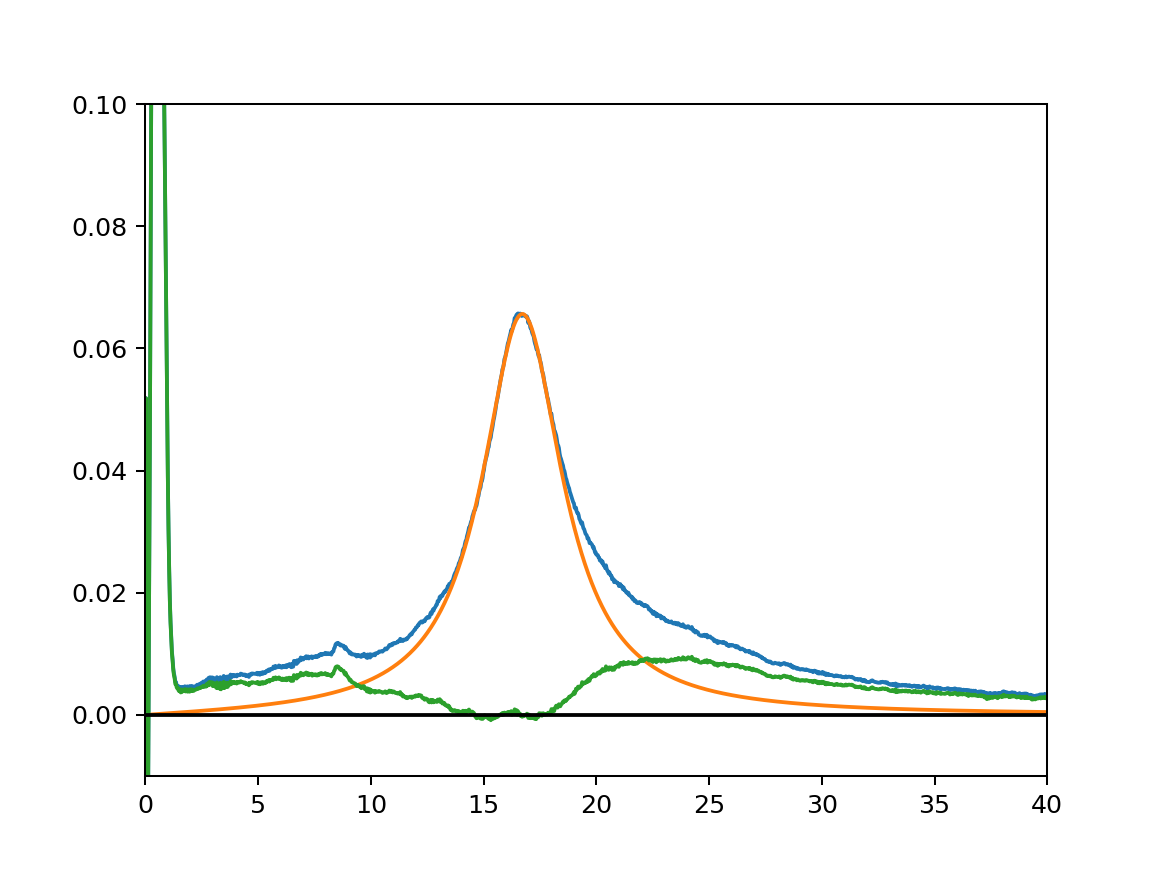

Drude Theory with Plamson Energy: 16.854267 eV and plasmon Width 4.34 eV
Max of Plasmon at 16.71 eV
Amplitude of  0.02 was deteremined by fit 


In [9]:
from scipy.optimize import leastsq

def Drude(E,Ep,Ew):
    eps = 1 - Ep**2/(E**2+Ew**2) +1j* Ew* Ep**2/E/(E**2+Ew**2)
    elf = (-1/eps).imag
    return eps,elf

def errfDrude(p, y, x):
    eps,elf = Drude(x,p[0],p[1])
    err = y - p[2]*elf
    #print (p,sum(np.abs(err)))
    return np.abs(err)#/np.sqrt(y)


pin2 = np.array([22,2,70])

startFit =np.argmin(abs(E-14))
endFit = np.argmin(abs(E-18))
    
p2, lsq = leastsq(errfDrude, pin2, args=(ssdLL[startFit:endFit], E[startFit:endFit]), maxfev=2000)

eps, elf =Drude(E,p2[0],p2[1])
drudePSD = p2[2]* elf
plt.figure()

plt.plot(E,ssdLL)
plt.plot(E,drudePSD)
plt.plot(E,ssdLL-drudePSD)
plt.plot([0,E[-1]],[0,0],c='black')

plt.gca().set_xlim(0,40)
plt.gca().set_ylim(-0.01,0.1)
print(f"Drude Theory with Plamson Energy: {p2[0]:2f} eV and plasmon Width {p2[1]:.2f} eV") 
print(f"Max of Plasmon at {energy_scale[drudePSD.argmax(0)]:.2f} eV")
print(f"Amplitude of  {p2[2]:.2f} was deteremined by fit ")


<IPython.core.display.Javascript object>


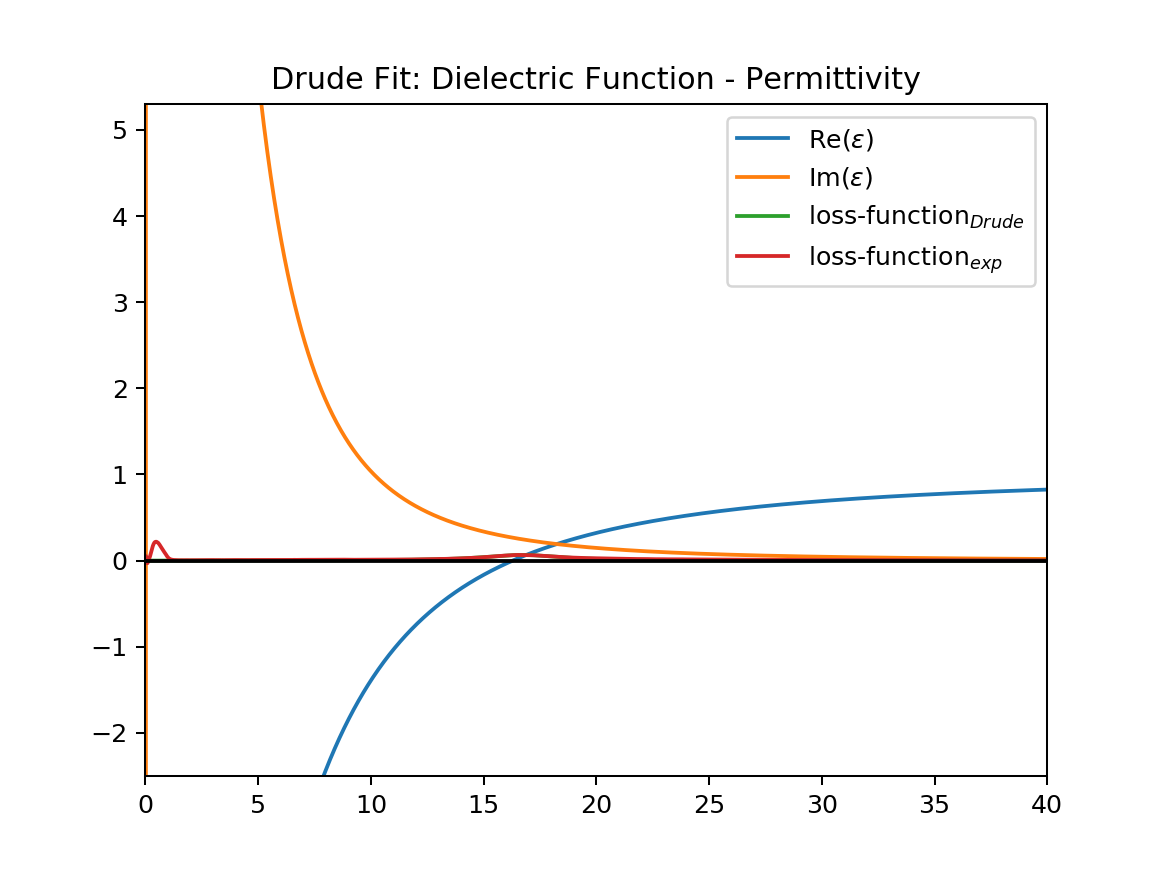

In [10]:
plt.figure()
plt.title ('Drude Fit: Dielectric Function - Permittivity')
plt.plot(E,eps.real,label = 'Re($\epsilon)$')
plt.plot(E,eps.imag,label = 'Im($\epsilon)$')
plt.plot(E,drudePSD,label = 'loss-function$_{Drude}$')
plt.plot(E,ssdLL,label = 'loss-function$_{exp}$')


plt.plot([0,E[-1]],[0,0],c='black')

plt.gca().set_xlim(0,40)
plt.gca().set_ylim(-2.5,5.3)

plt.legend();

## Kramer-Kronig Analysis

Kramers-Kronig actually give the thickness and then the IMFP $\lambda$ if one knows the index of reflection.

The Kramers-Kronig analysis expects an optical spectrum with $q=0$, so for a normal EELS spectrum an angular correction is needed or has to be recorded accordingly.


 LOOP  : 1,  t(nm) = 1.65, t/lambda = 0.002, lambda(nm) = 765.99
 LOOP  : 2,  t(nm) = -30.97, t/lambda = -0.037, lambda(nm) = 838.26
 LOOP  : 3,  t(nm) = -33.15, t/lambda = -0.036, lambda(nm) = 917.64
 LOOP  : 4,  t(nm) = -35.24, t/lambda = -0.035, lambda(nm) = 997.81
 LOOP  : 5,  t(nm) = -37.07, t/lambda = -0.035, lambda(nm) = 1072.65
 LOOP  : 6,  t(nm) = -38.57, t/lambda = -0.034, lambda(nm) = 1138.21
 LOOP  : 7,  t(nm) = -39.75, t/lambda = -0.033, lambda(nm) = 1193.17
 LOOP  : 8,  t(nm) = -40.63, t/lambda = -0.033, lambda(nm) = 1238.13
 LOOP  : 9,  t(nm) = -41.28, t/lambda = -0.032, lambda(nm) = 1274.60
 LOOP  : 10,  t(nm) = -41.75, t/lambda = -0.032, lambda(nm) = 1304.24
 LOOP  : 11,  t(nm) = -42.08, t/lambda = -0.032, lambda(nm) = 1328.51
 LOOP  : 12,  t(nm) = -42.31, t/lambda = -0.031, lambda(nm) = 1348.61
 LOOP  : 13,  t(nm) = -42.46, t/lambda = -0.031, lambda(nm) = 1365.44
 LOOP  : 14,  t(nm) = -42.56, t/lambda = -0.031, lambda(nm) = 1379.70
 LOOP  : 15,  t(nm) = -42.62, t/lamb

/home/nyd/.local/lib/python3.6/site-packages/ipykernel_launcher.py:77: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/nyd/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log


<IPython.core.display.Javascript object>


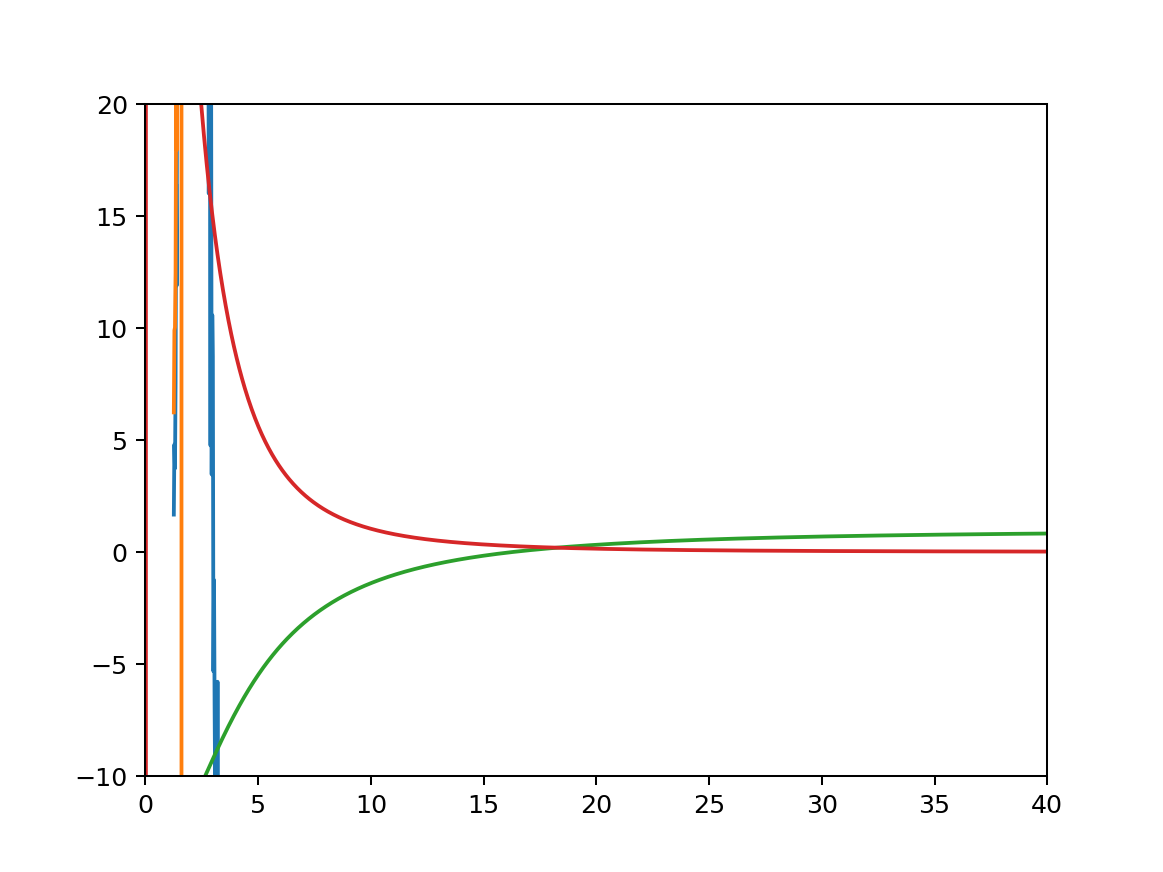

/home/nyd/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 40)

In [10]:
#function KraKro(infile,a0,e0,beta,ri,nloops,delta)
#     Kramers-Kronig analysis using Johnson method 
#     Program generates output into the 5-column file KRAKRO.DAT
## 
# Details in R.F.Egerton: EELS in the Electron Microscope, 3rd edition, Springer 2011


epc = energy_scale[1]-energy_scale[0]
#Read spectrum from input file
start = int(energy_scale[0]/epc)-1

#ssd = np.zeros(2048)

ssd = ssdLL[start:-1];  #% single-scattering distribution (intensity or probability)
#ssd = drudePSD[start:-1];
ssd[0] = 0


#e = s.tags['ene'][start:-1]-epc
e = np.linspace(1,epc*2*len(ssd),2*len(ssd))
d = np.zeros(len(ssd)*2,complex)
d[0:len(ssd)] = ssd
dssd = np.real(d)

a0 = zLoss.sum()#'Zero-loss sum 
e0 = spectrum_tags['acceleration_voltage']/1000.#input('E0(keV): ');
beta = 20 #input('BETA(mrad): ');
ri = 200.6 #('ref.index: ');
#' refractive index:  3.6 for silicon, 4 for germanium, > 100 for metals

nloops = 100# input('no. of iterations: ');
delta = 0.5# input('stability parameter (0.1 - 0.5 eV): ');


t = e0*(1.0 + e0/1022.12)/(1.0 + e0/511.06)**2; #%t=mv^2/2
rk0 = 2590.0*(1 + e0/511.06)*np.sqrt(2.0*t/511.06); #%k0 (wavenumber)
tgt = e0*(1022.12 + e0)/(511.06 + e0); #% 2.gamma.t

nn = len(d)
#%     Calculate Im(-1/EPS), Re(1/EPS), EPS1, EPS2 and SRFINT data:
tnm = 1; tnm_old = 100; num = 0
#for num in range(nloops):
while abs(tnm-tnm_old)> 1e-2:
    tnm_old = tnm   
    num += 1
    #%     Apply aperture correction APC at each energy loss:
    area = np.real(sum(d)); #Gerd was +a0 why?#%integral of [(dP/dE).dE]  
    apc=np.log(1.0+(beta * tgt / e)**2);
    d = d / apc;
    dsum = np.real(d/e).sum(); #% sum of counts/energy  
    
    ### calculate MFP with KK sum rule
    rk=dsum/1.571/(1.0 - 1.0/ri/ri);# was without epc % normalisation factor  *** no epc
    tnm = (332.5*rk/(a0)*e0*(1.0 + e0/1022.12))/(1.0 + e0/511.06)**2; #%*** no epc in denom
    tol = np.log(area/a0);
    tol = area/a0
    
    rlam = tnm/tol;
    print(f' LOOP  : {num},  t(nm) = {tnm:.2f}, t/lambda = {tol:.3f}, lambda(nm) = {rlam:.2f}');
    d = d / rk; #% Im(-1/eps)
    
    imreps = d; #% stored value, not to be transformed
    
    
    
    d = np.fft.fft(d);# % Fourier transform  
    
    d = -2.0 * np.imag(d) / nn ; #%Transfer sine coefficients to cosine locations:
    d[0:int(nn/2)] = -d[0:int(nn/2)];        
    
    d = np.real(np.fft.ifft(d)); #% Inverse transform
    
    
    #%       Correct the even function for reflected tail:
    dmid = np.real(d[int(nn/2)]);
    #d[0:nn/2] = np.real(d[0:nn/2]) + 1 - dmid/2 *((nn/2-1) /np.linspace(nn/2-1,0,nn/2))**2 *(1+0j);
    d[int(nn/2):nn] =1+dmid *((nn/2) /(np.linspace(nn/2,nn,nn/2)))**2 /2.0;
    
    #f(nn / 2 + j, 0) = 1# + f(nn / 2, 0) * ((nn - 1) / (nn + j)) ^ 2 / 2#
    #print(np.linspace(nn/2-1,0,nn/2))
    
    re = np.real(d);
    den = re *re + imreps *imreps; 
    eps1 = re / den;
    eps2 = imreps / den;
    
    #%       Calculate surface energy-loss function and surface intensity:
    srfelf = 4 *eps2/((1+eps1)**2+eps2**2) - imreps;# %has double-peak!!
    srfelf = srfelf
    #%eps=complex(eps1,eps2);
    #%srfelf=imag(-4./(1.+eps))- imreps(2:nn); %  gives SAME as above
    adep=tgt/(e+delta)*np.arctan(beta*tgt/e)-beta/1000./(beta**2+e**2./tgt**2);
    #% delta in range 0.1 to 0.5, according to Alexander&Crozier
    srfint = 2000.*rk/rk0/tnm*adep*srfelf;
    d= dssd - srfint; #% correct ssd for surface-loss intensity

    
    
    d[0] = 0;
end = 180

#plt.plot(s.tags['ene'][start:end],ssdLL[start:end])
#plt.plot(e[0:100],d[0:100])
eps1[0] = 0

plt.figure()
plt.plot(e[10:100],eps1[10:100]*50)
plt.plot(e[10:100],eps2[10:100]/2)
plt.plot(E,eps.real,label = 'Re($\epsilon)$')
plt.plot(E,eps.imag,label = 'Im($\epsilon)$')
plt.gca().set_ylim(-10,20)
plt.gca().set_xlim(-0,40)



In [11]:
plt.figure()
plt.plot(e,eps1)
plt.plot(e,eps2*10)
plt.plot(energy_scale,np.real(spectrum_tags['eps']))
plt.plot(energy_scale,np.imag(spectrum_tags['eps']))
plt.ylim(-2,20)
plt.xlim(0,6)
plt.title ('Dielectric Function')

<IPython.core.display.Javascript object>

/home/nyd/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


KeyError: 'eps'

## Back: [Fit Zero-Loss](FitZeroLoss.ipynb)
## Next: [Momentum Resolved EELS](Dispersion.ipynb)

## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)
## Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)